In [ ]:
!pip install -q numpy pandas sklearn xgboost
!pip install -q vectice
!pip install -q fsspec
!pip install -q gcsfs 
!pip install -q mlflow

In [2]:
import numpy as np
import pandas as pd
import os, sys
import logging

from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from vectice import Vectice
import mlflow

In [ ]:
!pip show vectice

### Detecting Parkinson's with XGBoost

In this example we're building a model with XGBoost to detect Parkinson's in individuals. A data split run will be demonstrated with the Vectice SDK. MLflow will be used to capture the experiment runs and the models performance. The Vectice integration with MLflow will be displayed aswell. Furthermore, the Vectice Fluent implementation is being used. Vectice MLflow adapter fluent usage in Python uses ``with`` syntax.

In [ ]:
# Upload your GCS Storage json for access to GCS
from google.colab import files
uploaded = files.upload()

## Vectice Credentials 

To connect to the Vectice App through the SDK you'll need the Project Token, Vectice API Endpoint and the Vectice API Token. You'll find all of this in the Vectice App. The Workspace allows you to create the Vectice API Token, in Projects you'll be able to get the Project Token, as seen below. The Vectice API Endpoint is 'https://be-beta.vectice.com'. You're provided with the GCS Service Account JSON, this will allow you to connect to the GCS Bucket in the Vectice App and get the needed data for the example. 

### Project Token 

The Project token is in the project settings in the Vectice UI.
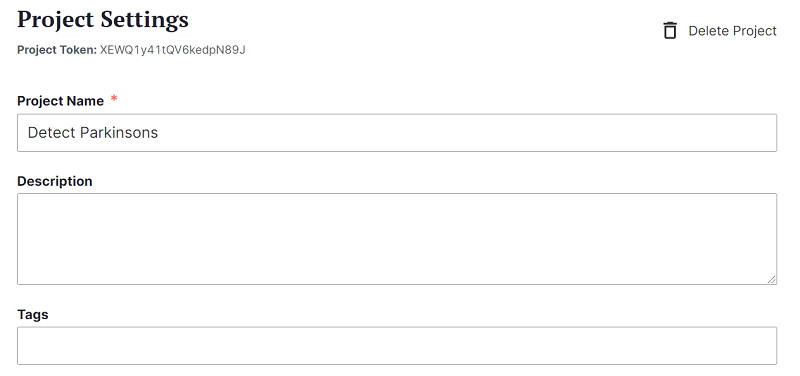


## Credentials Setup:
The Vectice API Endpoint and Token are needed to connect to the Vectice UI. Furthermore, a Google Cloud Storage credential JSON is needed to connect to the Google Cloud Storage to retrieve and upload the datasets. A project token links the runs to the relevant project and it's needed to create runs.

In [6]:
# Project token from Vectice UI
PROJECT_TOKEN = "PROJECT_TOKEN"
# The API Endpoint and Vectice API 
os.environ['VECTICE_API_ENDPOINT'] ='https://be-beta.vectice.com'
os.environ['VECTICE_API_TOKEN'] = 'API_TOKEN'
# Your Google Cloud Storage json
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'FILE_NAME.json'


This is how the csv could be pushed into GCS. We're doing the reading below the step here but you would read in the data the first time from it's source and then push it into GCS. After that you could just read it from GCS. 
```
df.to_csv("gs://vectice-examples-samples/Detect_Parkinsons/parkinsons.data")
```

In [ ]:
# Get data from GCS Storage bucket
df = pd.read_csv("gs://vectice-examples-samples/Detect_Parkinsons/parkinsons.data", index_col=0) 
df.head()

In [ ]:
# Check for missing data
df.isnull().sum().sort_values()

### Inputs

The inputs of the runs are represented as assets in the Vectice UI. When searching for these assets you just need to use the "Parent Name" so in this case it's Split and Parkinsons Data. Furthermore, these assets shown below are datasets. In an actual real world run you would do the following:

#### Workflow: 
- Load in Parkinsons data into GCS -> pd.to_csv("gs://data.csv")
- Create the dataset asset in Vectice
- Create and start run with Parkinsons as an input
- Perform the Train, Test Split
- Load this new Train, Test Split data into GCS -> pd.to_csv("gs://data.csv")
- Create the dataset asset in Vectice
- End run with the Train, Test Split as an output

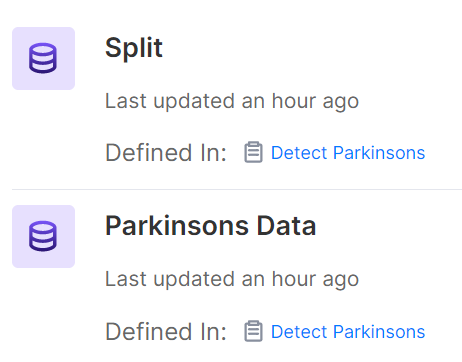

In [ ]:
# Starting a run
vectice = Vectice(project_token=PROJECT_TOKEN)
# create_dataset_version creates an input or output for the run, you link an existing dataset in the vectice backend via "with_parent_name()"
# You'll need to a
ds_version = [vectice.create_dataset_version().with_parent_name("Parkinsons Data")]
# create_run creates the job you're about to do in the backend
run = vectice.create_run('Splitting', JobType.PREPARATION)
# Start run then gets the ball rolling
vectice.start_run(run, ds_version)

In [10]:
# Get the features and labels
features = df.loc[:,df.columns!='status'].values[:,1:]
labels = df.loc[:,'status'].values

In [ ]:
# Get the count of each label (0 and 1) in labels
labels[labels==1].shape[0], labels[labels==0].shape[0]

(147, 48)

In [13]:
X = features[:,1:]
y = labels

In [14]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [15]:
X_data = pd.DataFrame(X)
y_data = pd.DataFrame(y)

Push the X and y data into GCS. This is an example of how it could be done as seen above. 
```
y_data.to_csv("gs://test-vectice-storage/sdk_test-an/Parkinsons/data/y_data.csv")
X_data.to_csv("gs://test-vectice-storage/sdk_test-an/Parkinsons/data/X_data.csv")
```

## Run Output 
The run output appears as below and you'll see the distinction on the right with the linkage of the input and the output of said run. The datasets and their versions appear on the left in relation to their usage of being an input or an output. If the datasets are changed in GCS then Vectice picks up the Metadata changes and the datset version updates.

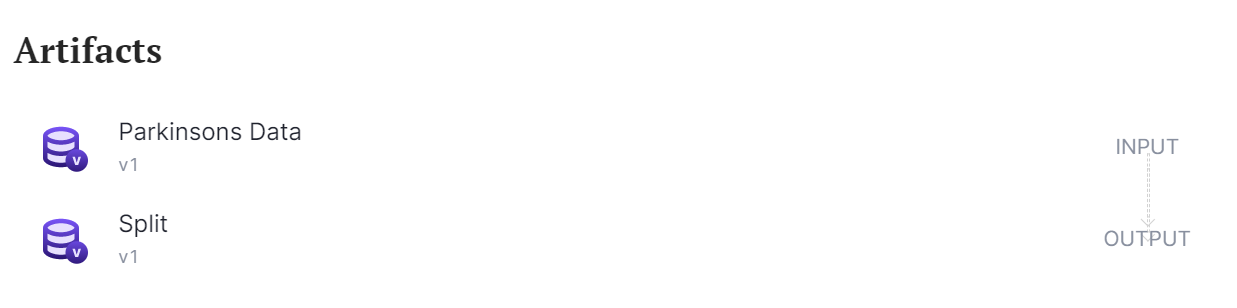

In [ ]:
# When you want to assign outputs that link to your inputs you'd create outputs. Outputs can be data/models.
outputs = [vectice.create_dataset_version().with_parent_name("Train-Test-Split")]
# End the run and save the new dataset version.
# Set the Split data as an output.
vectice.end_run(outputs=outputs)

In [ ]:
# Scale the features to between -1 and 1
scaler = MinMaxScaler((-1,1))
scaler.fit(X_train)

In [20]:
# Create the inputs for the MLflow run as done above. Steps are inputs -> create_run -> start_run -> outputs -> end_run. MLflow handles the outputs for you as it captures the model meta data.
input = [vectice.create_dataset_version().with_parent_name("Train-Test-Split")]

In [ ]:
import warnings
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO)
"""Vectice MLflow adapter fluent usage in Python ``with`` syntax."""
MLFLOW_EXPERIMENT_NAME = "XGBC-Experiment"

# Standard MLflow tracking and autolog is silent to reduce output
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.autolog(silent=True)

# Pipeline Setup
XGB = XGBClassifier()
pipe = Pipeline([("scaler", scaler), ("XGB", XGB)])

# Fit 
pipe.fit(X_train, y_train)

# Set up Vectice MLflow adapter
vectice = Vectice(project_token=PROJECT_TOKEN, lib="MLflow")
run = vectice.create_run(MLFLOW_EXPERIMENT_NAME)

with vectice.start_run(run, inputs=input):
    # Predictions and metric being used
    y_pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Standard MLflow logging, which is then captured by Vectice. 
    mlflow.log_param('algorithm', MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param('Scaler', 'StandardScaler')
    mlflow.log_metric("accuracy", round(accuracy, 4))
    print(f"{MLFLOW_EXPERIMENT_NAME}: {accuracy}")

### Output of MLflow Integration 

The MLflow integration captures the parameters algorithm and Scaler. The metric accuracy is also captured. Furthermore, each run is assigned a version and this happens because the model name renames the same. If it's chnaged then a new model would be tracked. So model names are important to ensure you're tracking the correct model and version iterations when running experiments.
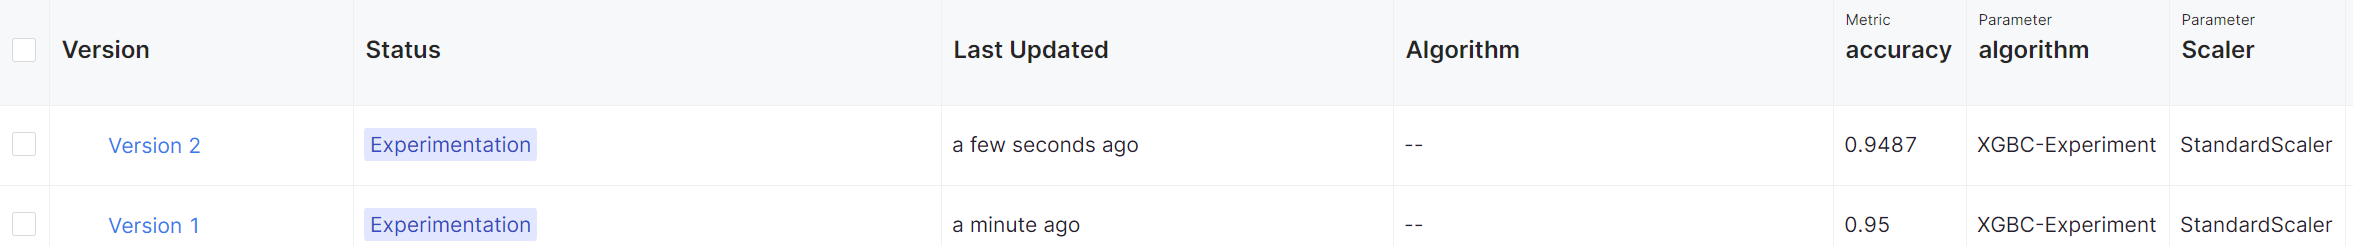


In [ ]:
# If anything goes wrong then you need to use the following to end runs. 
mlflow.end_run()
vectice.end_run()